# Assignment 5 - Neural Architecture Search (NAS)

In this assignment, Neural Architecture Search (NAS) will be implemented. The goal of NAS is to find the best neural network architecture for a given task. The dataset that will be used in this assignment is Scikit Learn-Digits (same as assignment 4). The possible configurations of the NN are given in the instructions. 


In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn import datasets
from sklearn.datasets import load_digits
from torch.utils.data import DataLoader, Dataset

EPS = 1.0e-7

In [2]:
# Uncomment the following lines if you run on Colab
#from google.colab import drive
#drive.mount("/content/gdrive")
#results_dir = "/content/gdrive/MyDrive/CI"


## Dataset

The same dataset code from assignment 4 will be used here.

In [3]:
# import libraries for dataset
from sklearn.datasets import load_digits
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import Dataset, random_split
from torchvision import transforms
from sklearn.model_selection import train_test_split

In [4]:
# Following class for Digits dataset is taken from Assignment-4 
# This is a class for the dataset of small (8px x 8px) digits.
class Digits(Dataset):
    """Scikit-Learn Digits dataset."""

    def __init__(self, mode="train", transforms=None):
        digits = load_digits()
        if mode == "train":
            self.data = digits.data[:1000].astype(np.float32)
            self.targets = digits.target[:1000]
        elif mode == "val":
            self.data = digits.data[1000:1350].astype(np.float32)
            self.targets = digits.target[1000:1350]
        else:
            self.data = digits.data[1350:].astype(np.float32)
            self.targets = digits.target[1350:]

        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample_x = self.data[idx]
        sample_y = self.targets[idx]
        if self.transforms:
            sample_x = self.transforms(sample_x)
        return (sample_x, sample_y)

In [5]:
# Initialize training, validation and test sets.
train_data = Digits(mode="train")
val_data = Digits(mode="val")
test_data = Digits(mode="test")

# Initialize data loaders.
training_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

## Neural Network Architecture

This section includes the implementation of a convolutional neural network of the following form:

    Conv2d → f(.) → Pooling → Flatten → Linear 1 → f(.) → Linear 2 → Softmax 
    
However, different choices in each building block are allowed as follows:

● Conv2d:
  - Number of filters: 8, 16, 32
  - kernel=(3,3), stride=1, padding=1 OR kernel=(5,5), stride=1, padding=2
  
● f(.):
  - ReLU OR sigmoid OR tanh OR softplus OR ELU

● Pooling:
  - 2x2 OR Identity
  - Average OR Maximum

● Linear 1:
  - Number of neurons: 10, 20, 30, 40, 50, 60, 70, 80, 90, 100

Altogether, there are 1200 possible configurations.

### Necessary Functions for NN Architecture

In [6]:
# The following code is taken from Assignment-4 
# This module reshapes an input (matrix -> tensor).
class Reshape(nn.Module):
    def __init__(self, size):
        super(Reshape, self).__init__()
        self.size = size  # a list

    def forward(self, x):
        assert x.shape[1] == np.prod(self.size)
        return x.view(x.shape[0], *self.size)

# This module flattens an input (tensor -> matrix) by blending dimensions
# beyond the batch size.
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(x.shape[0], -1)


In [7]:
def architecture_decoder(encoded_config, input_size=8, input_depth=1):
    '''
    This function accepts an encoded configuration and returns the corresponding architecture.
    Args:
        encoded_config (list): encoded configuration of 3 + 2 + 5 + 2 + 2 + 10 = 24 digits of 0 or 1
        input_size (int): the size of a one dimension (width or height) of the input image
        input_depth (int): the depth of the input image
        - The input image is assumed to be square and have the same width and height. - 
        - Input of a NN will have size of input_size x input_size x input_depth -
    Returns:
        classnet (nn.Module): the corresponding architecture with the given encoded configuration
        of     
        Conv2d → f(.) → Pooling → Flatten → Linear 1 → f(.) → Linear 2 → Softmax 
    '''
    # sanity checks on the input 
    assert len(encoded_config) == 24, "encoded_config must be 24 digits"
    assert all([x in [0, 1] for x in encoded_config]), "encoded_config must consits of 0 or 1"
    # divide the encoded_config into corresponding parts
    conv1_filter_part = encoded_config[:3]
    conv1_kernel_part = encoded_config[3:5]
    f_part = encoded_config[5:10]
    pooling_size_part = encoded_config[10:12]
    pooling_method_part = encoded_config[12:14]
    fc_part = encoded_config[14:]
    # check there is only one 1 in each group of 3 + 2 + 5 + 2 + 2 + 10 
    assert sum([int(x) for x in conv1_filter_part]) == 1, "conv1_filter_part must have only one 1"
    assert sum([int(x) for x in conv1_kernel_part]) == 1, "conv1_kernel_part must have only one 1"
    assert sum([int(x) for x in f_part]) == 1, "f_part must have only one 1"
    assert sum([int(x) for x in pooling_size_part]) == 1, "pooling_size_part must have only one 1"
    assert sum([int(x) for x in pooling_method_part]) == 1, "pooling_method_part must have only one 1"
    assert sum([int(x) for x in fc_part]) == 1, "fc_part must have only one 1"
    
    # decode number of filters
    filter_no = 8 if conv1_filter_part[0] == 1 else 16 if conv1_filter_part[1] == 1 else 32
    # decode kernel size
    kernel_size = 3 if conv1_kernel_part[0] == 1 else 5
    padding = 1 if kernel_size == 3 else 2
    stride = 1 
    # decode f
    f = nn.ReLU() if f_part[0] == 1 else nn.Sigmoid() if f_part[1] == 1 else nn.Tanh() if f_part[2] == 1 else nn.Softplus() if f_part[3] == 1 else nn.ELU()
    # decode pooling size
    pooling_size = 2 if pooling_size_part[0] == 1 else 1
    # decode pooling method
    pooling_method = nn.MaxPool2d if pooling_method_part[0] == 1 else nn.AvgPool2d
    # decode fc
    # Number of neurons: 10, 20, 30, 40, 50, 60, 70, 80, 90, 100
    neuron_no = 10 if fc_part[0] == 1 else 20 if fc_part[1] == 1 else 30 if fc_part[2] == 1 else 40 if fc_part[3] == 1 else 50 if fc_part[4] == 1 else 60 if fc_part[5] == 1 else 70 if fc_part[6] == 1 else 80 if fc_part[7] == 1 else 90 if fc_part[8] == 1 else 100

    # calculate the input size of the first linear layer
    # the input size of the first linear layer is the output size of the last pooling layer
    # the output size of the last pooling layer is calculated as follows:
    # output_size = (input_size - kernel_size + 2 * padding) / stride + 1
    output_of_conv = (input_size - kernel_size + 2 * padding) / stride + 1
    output_of_pooling = output_of_conv / pooling_size
    output_of_flatten = output_of_pooling ** 2 * filter_no

    # create the architecture
    classnet = nn.Sequential(
        # Reshape the input to a vector
        Reshape(size=(input_depth, input_size, input_size)),
        nn.Conv2d(input_depth, filter_no, kernel_size=kernel_size, stride=stride, padding=padding),
        f,
        pooling_method(pooling_size),
        Flatten(),
        nn.Linear(int(output_of_flatten), neuron_no),
        f,
        nn.Linear(neuron_no, 10),
        nn.Softmax(dim=1)
    )

    # calculate number of weights to be used in calculation of  objective function for EA
    # to see details of calculation please see the cell below
    number_of_weights = (kernel_size * kernel_size * input_depth + 1)* filter_no + ((output_of_flatten+1) * neuron_no) + ((neuron_no+1) * 10)
    return classnet, number_of_weights

#### Weight Number

In [8]:
# Weights for different layers can be calculated as follows:
# CONV = (KERNEL_SIZE**2 * INPUT_CHANNEL)* OUTPUT_CHANNEL
# FC = INPUT_SIZE* OUTPUT_SIZE
# Pooling, ReLU, Sigmoid, etc does not have any weights
# Then we know that for same kernel size as the number of filters increases the number of weights are increased
# Moreover, the number of filters are also effects the input size of the first linear layer thus as it increases the number of weights are increased
# Also neuron number in the first linear layer should be maximized to increase the number of weights as it increases weights in first layer and higher input size for the second linear layer 
# For kernel size we know that as it increases the number of weights are increased however, it may also reduce the input size of the first linear
# Thus we need to understand which one is more effective
# For the given configs, output size of the conv layer stays the same for both cases as one is 3x3 with stride 1 pad 1 and other is 5x5 with stride 1 pad 2 
# given the formulation of O = I - K + 2P / S + 1 we can observe they stay the same so both are equal 
# thus maximum number of weights are calculated as follows:
# choose maximum kernel size, maximum neuron output size for first layer and also add the weights of the second linear layer
# +1 represents the bias term
Nmax = (5 * 5* 1 + 1 ) * 32 + ((64*32+1) * 100) + ((100 +1) * 10)
print("Maximum number of weights for the given architecture is: ", Nmax)
    

Maximum number of weights for the given architecture is:  206742


In [9]:
def init_generation_creator(population_size, split_indexes,length):
    '''
    This function creates the initial generation of binary representation 
    to represent the initial population of the genetic algorithm.
    Args:
        population_size (int): the size of the population
        split_indexes (list): the split points of the binary representation
        in our case, the split points are [0, 3, 5, 10, 12, 14]
        length (int): the length of overall gen
    Returns:
        population (list): the initial population of the genetic algorithm
    '''
    population = []
    for i in range(population_size):
        ind = [0]*length
        for j in range(len(split_indexes)-1):
            #print('For indexes between {} and {}'.format(split_indexes[j],split_indexes[j+1]))
            one_ind = np.random.choice(range(split_indexes[j],split_indexes[j+1]), size=1)
            #print('Chosen index is: ', one_ind)
            ind[int(one_ind)] = 1
        #print('For indexes between {} and {}'.format(split_indexes[-1],length))
        one_ind = np.random.choice(range(split_indexes[-1],length), size=1)
        #print('Chosen index is: ', one_ind)
        ind[int(one_ind)] = 1
        population.append(ind)
    return population



### NN

In [10]:
# Following classifier code is taken from Assignment-4
class ClassifierNeuralNet(nn.Module):
    def __init__(self, classnet):
        super(ClassifierNeuralNet, self).__init__()
        # We provide a sequential module with layers and activations
        self.classnet = classnet
        # The loss function (given in the instruction)
        self.cel = nn.CrossEntropyLoss(reduction="none")  

    # This function classifies an image x to a class.
    # The output must be a class label (long).
    def classify(self, x):
        # ------
        # PLEASE FILL IN
        # calculate scores of given classnet
        scores = self.classnet(x)
        # predict the label based on highest score
        y_pred = scores.argmax(dim=1)
        # cast to long
        y_pred = y_pred.long()
        return y_pred

    # This function is crucial for a module in PyTorch.
    # In our framework, this class outputs a value of the loss function.
    def forward(self, x, y, reduction="avg"):
        # ------
        # PLEASE FILL IN
        # crossentropy loss between result and the target
        loss = self.cel(self.classnet(x), y)
        # return the loss based on reduction
        if reduction == "sum":
            return loss.sum()
        else:
            return loss.mean()
    
        

In [11]:
# The training procedure outline is from Assignment 4 part-2, however changes are made for the given task
def training(
    name, max_patience, num_epochs, model, optimizer, training_loader, val_loader, verbose=False
):
    cel_val = []
    error_val = []
    best_cel = 1000.0
    best_error_val = 1000.0
    patience = 0
    model_best_of_epochs = None
    # Main training loop
    for e in range(num_epochs):
        model.train()  # set the model to the training mode
        # load batches
        for indx_batch, (batch, targets) in enumerate(training_loader):
            # calculate the forward pass (loss function for given images and labels)
            loss = model.forward(batch, targets)
            # remember we need to zero gradients! Just in case!
            optimizer.zero_grad()
            # calculate backward pass
            loss.backward(retain_graph=True)
            # run the optimizer
            optimizer.step()

        # Validation: Evaluate the model on the validation data
        loss_e, error_e = evaluation(val_loader, model_best=model, epoch=e, verbose=verbose)
        cel_val.append(loss_e)  # save for plotting
        error_val.append(error_e)  # save for plotting

        # Early-stopping: update the best performing model and break training if no
        # progress is observed.
        if e == 0:
            torch.save(model, name + ".model")
            best_cel = loss_e
        else:
            if loss_e < best_cel:
                torch.save(model, name + ".model")
                best_cel = loss_e
                patience = 0
                model_best_of_epochs = model
                best_error_val = error_e
            else:
                patience = patience + 1

        if patience > max_patience:
            break

    # Return the best model and the corresponding classification error for this configuration
    return model_best_of_epochs, best_error_val, best_cel
  
# The evaluation procedure outline is from Assignment 4 part-2, however changes are made for the given task
def evaluation(test_loader, name=None, model_best=None, epoch=None, verbose=False):
    # If available, load the best performing model
    if model_best is None:
        model_best = torch.load(name + ".model")

    model_best.eval()  # set the model to the evaluation mode
    loss_test = 0.0
    loss_error = 0.0
    N = 0.0
    # start evaluation
    for indx_batch, (test_batch, test_targets) in enumerate(test_loader):
        # loss
        loss_test_batch = model_best.forward(test_batch, test_targets, reduction="sum")
        loss_test = loss_test + loss_test_batch.item()
        # classification error
        y_pred = model_best.classify(test_batch)
        e = 1.0 * (y_pred == test_targets)
        loss_error = loss_error + (1.0 - e).sum().item()
        # the number of examples
        N = N + test_batch.shape[0]
    # divide by the number of examples
    loss_test = loss_test / N
    loss_error = loss_error / N

    # Print the performance
    if epoch is None:
        print(f"-> FINAL PERFORMANCE: cel={loss_test}, ce={loss_error}")
    else:
        if verbose and epoch % 2 == 0:
            print(f"Epoch: {epoch}, val cel={loss_test}, val ce={loss_error}")

    return loss_test, loss_error


## EA

In [12]:
class EA_for_NAS(object):
    def __init__(self, pop_size, split_indexes, k = 2, sp = 1.5, recombination_rate = 0.5, mutation_rate = 0.5, scaling_factor = 1.5):
        self.pop_size = pop_size
        # the indexes that are starting index of different representation areas
        # in our case = [0,3,5,10,12,14]
        #i.e. first coding part is [0:3], second is [3:5], ... , [12:14], [14:]
        self.split_indexes = split_indexes
        self.k = k
        # selection pressure
        self.sp = sp
        # RECIMBINATION HYPERPARAMETERS
        # recombination rate
        self.recombination_rate = recombination_rate
        # MUTATION HYPERPARAMETERS
        # mutation rate
        self.mutation_rate = mutation_rate
        # scaling factor
        self.scaling_factor = scaling_factor
        self.model_metric_dict = {}

    def linear_ranking_selection(self, x_old, f_old):
        # linear ranking selecting
        # formula is the following:
        # p_i = 1/n * (sp - (2sp-2)*rank_i/(n-1)) where sp is the selection pressure with value is in [1,2]
        # and rank_i is the rank of the individual i
        # first we calculate the rank
        rank = np.argsort(f_old)
        # sort parents based on their fitness
        x_old = [x for _, x in sorted(enumerate(x_old), key=lambda pair: (-f_old[pair[0]], pair[0]))]
        # then we calculate the selection probability
        n = len(x_old)
        selection_probability = 1/n * (self.sp - (2*self.sp-2)*rank/(n-1))
        # now create a line with the selection probability spaces 
        selection_line = np.zeros(n)
        for i in range(n):
            selection_line[i] = np.sum(selection_probability[:i])
        # now we choose the parents based on the selection probability line
        x_parents = np.zeros((n, len(x_old[0])))
        f_parents = np.zeros((n,))
        for i in range(n):
            # select a random number between 0 and 1 uniformly
            rand = np.random.uniform(0,1)
            # go over each element in the selection line from start to end
            for j in range(n):
                # if the random number is smaller than the selection line element then choose that parent
                if rand < selection_line[j]:
                    x_parents[i] = x_old[j]
                    f_parents[i] = f_old[j]
                    break
                if j == n-1:
                    # if not greater then any previous element then choose the last parent
                    x_parents[i] = x_old[n-1]
                    f_parents[i] = f_old[n-1] 
                        
        return x_parents, f_parents

    def parent_selection(self, x_old, f_old):
        # linear ranking selection
        x_parents, f_parents = self.linear_ranking_selection(x_old, f_old)

        return x_parents, f_parents

    def one_point_crossover(self, x1, x2):
        # choose a crossover point based on split_indexes 
        # only divide the set from split indexes so that the rules for binary representation will apply
        idx = int(np.random.choice(self.split_indexes, size=1))
        while idx == 0:
            idx = int(np.random.choice(self.split_indexes, size=1))
        # do crossover from index
        x1[idx:], x2[idx:] = x2[idx:].copy(), x1[idx:].copy()
        # return the crossovered versions
        return x1, x2

    
    def n_point_crossover(self, x1, x2, n):
        if n == 'uniform':
            # this is just to be sure that they are always the same length (although this is the case in our case just to be sure)
            n = len(self.split_indexes)
        else:
            # check if n is smaller than split points
            n = int(n)
            if n > len(self.split_indexes):
                # if so, then set n to the length of the parents
                n = len(self.split_indexes)
                
        # choose n crossover points
        crossover_points = np.random.choice(self.split_indexes, n)
        # sort the crossover points
        crossover_points.sort()
        # do crossover from index
        if n % 2 == 0:
            for i in range(0, n-1, 2):
                x1[crossover_points[i]:crossover_points[i+1]], x2[crossover_points[i]:crossover_points[i+1]] = x2[crossover_points[i]:crossover_points[i+1]].copy(), x1[crossover_points[i]:crossover_points[i+1]].copy()
        else:
            for i in range(0, n-2, 2):
                x1[crossover_points[i]:crossover_points[i+1]], x2[crossover_points[i]:crossover_points[i+1]] = x2[crossover_points[i]:crossover_points[i+1]].copy(), x1[crossover_points[i]:crossover_points[i+1]].copy()

        # return the crossovered versions
        return x1, x2

    def recombination(self, x_parents, f_parents):
        # first copy the parents into the children
        x_children = x_parents.copy()
        # for population size, choose if there will be a crossover or not
        for i in range(self.pop_size):
            # if there is a crossover
            if np.random.rand() < self.recombination_rate:
                # choose the parents to perform crossover 
                p1, p2 = np.random.choice(self.pop_size, 2, replace=False)
                # choose the crossover type: 0.5 -> one point, 0.25 -> two point, 0.20 -> 3 point, 0.05 -> uniform
                crossover_type = np.random.rand()
                
                if crossover_type < 0.5:
                    x_children[p1], x_children[p2] = self.one_point_crossover(x_parents[p1], x_parents[p2])
                elif crossover_type < 0.75:
                    x_children[p1], x_children[p2] = self.n_point_crossover(x_parents[p1], x_parents[p2], n='2')
                elif crossover_type < 0.95:
                    x_children[p1], x_children[p2] = self.n_point_crossover(x_parents[p1], x_parents[p2], n='3')
                else:
                    x_children[p1], x_children[p2] = self.n_point_crossover(x_parents[p1], x_parents[p2], n='uniform')
                
        return x_children

    def mutation(self, x_children):
        # for each child, choose if there will be a mutation or not
        for i in range(self.pop_size):
            # if there is a mutation
            child = x_children[i]
            if np.random.rand() < self.mutation_rate:
                # for each of the split points, choose if there will be a mutation or not
                for j in range(len(self.split_indexes)-1):
                    # if there is a mutation on that part
                    if np.random.rand() < self.mutation_rate:
                        # find where the bit has value 1 
                        idx = np.where(child[self.split_indexes[j]:self.split_indexes[j+1]] == 1)[0] + self.split_indexes[j]
                        # find the new index of the bit that will have value 1
                        new_idx = int(np.random.choice(np.arange(self.split_indexes[j], self.split_indexes[j+1]), size=1))
                        # if the new index is the same as the old one, then not mutation will occur
                        #print('Search between {} and {}'.format(self.split_indexes[j], self.split_indexes[j+1]))
                        #print('Found 1 at index {}'.format(idx))
                        #print('New index is {}'.format(new_idx))
                        child[idx] = 0
                        child[new_idx] = 1
                # for the last part
                if np.random.rand() < self.mutation_rate:
                    # find where the bit has value 1 
                    idx = np.where(child[self.split_indexes[-1]:] == 1)[0]+ self.split_indexes[-1]
                    # find the new index of the bit that will have value 1
                    new_idx = int(np.random.choice(np.arange(self.split_indexes[-1], len(child)), size=1))
                    # if the new index is the same as the old one, then not mutation will occur
                    child[idx] = 0
                    child[new_idx] = 1
        return x_children

    def survivor_selection(self, x_old, x_children, f_old, f_children):
        # elitism selection
        # first select the best k individuals from the old population
        x_old_best = [x for _, x in sorted(enumerate(x_old), key=lambda pair: (-f_old[pair[0]], pair[0]))][:self.k]
        f_old_best = sorted(f_old, reverse=True)[:self.k]
        # drop the selected x_old_best and corresponding f_old_best individuals from the old population 
        x_old =  [x for _, x in sorted(enumerate(x_old), key=lambda pair: (-f_old[pair[0]], pair[0]))][self.k:]
        f_old = sorted(f_old, reverse=True)[self.k:]
        # now (μ, λ) selection 
        # first sort the children based on their fitness
        x_children =[x for _, x in sorted(enumerate(x_children), key=lambda pair: (-f_children[pair[0]], pair[0]))]
        f_children = sorted(f_children, reverse=True)
        # now select the rest of the population based on the fitness only on children
        # first let us make sure that there is enough children to fill the population
        if self.pop_size - self.k > len(x_children):
            # if not, apply (μ + λ) selection
            # this is only to make sure that the code is robust
            x = np.concatenate((x_old, x_children))
            f = np.concatenate((f_old, f_children))
            # sort the new population based on their fitness
            x =  [x for _, x in sorted(enumerate(x), key=lambda pair: (-f[pair[0]], pair[0]))]
            f =  sorted(f, reverse=True)
            # now select the best individuals
            x = x[:self.pop_size]
            f = f[:self.pop_size]
        else:
            # apply (μ, λ) selection
            x = np.concatenate((x_old_best, x_children[:self.pop_size-self.k]))
            f = np.concatenate((f_old_best, f_children[:self.pop_size-self.k]))

        return x, f
    

    def evaluate(self, x, generation_number, max_patience = 0, num_epochs = 10, lr = 0.001, wd = 0.0001, k = 10, result_dir = 'results/', name = 'test', split_indexes = [0,3,5,10,12,14], lambda_fitness = 0.01):
        f = []
        gen_dict = {}
        for config in x:
            classnet, number_of_weights = architecture_decoder(config)
            name = ''.join(str(config))
            # train the network
            model = ClassifierNeuralNet(classnet)
            optimizer = torch.optim.Adamax(
                [p for p in model.parameters() if p.requires_grad == True],
                lr=lr,
                weight_decay=wd,
            )

            # Training procedure
            model, error_val, cel_val = training(
                name=result_dir + name,
                max_patience=max_patience,
                num_epochs=num_epochs,
                model=model,
                optimizer=optimizer,
                training_loader=training_loader,
                val_loader=val_loader,
            )
            # calculate the fitness
            # Objective=ClassError+λ 𝑁𝑝 /𝑁𝑚𝑎𝑥
            # where 𝑁𝑝 denotes the number of weights of a model and 𝑁𝑚𝑎𝑥 
            # denotes the number of weights of the largest model in the population
            fitness = error_val + lambda_fitness * (number_of_weights/ Nmax)
            f.append(fitness)
            # also to track of each model, save the model and its errors to the main class
            gen_dict[name] = {'model': model, 'error': error_val, 'cel': cel_val, 'fitness': fitness}
        self.model_metric_dict[generation_number] = gen_dict
        return f

  
    def step(self, x_old, f_old, generation_number):
        # -------
        # PLEASE FILL IN
        # NOTE: This function must return x, f
        # where x - population
        #       f - fitness values of the population
        # -------
        #print('Initial population: ', x_old)

        x_parents, f_parents = self.parent_selection(x_old, f_old)
        
        #print('Parents: ', x_parents)
        x_children = self.recombination(x_parents, f_parents)
        #print('Children: ', x_children)

        x_children = self.mutation(x_children)
        #print('Mutated children: ', x_children)

        f_children = self.evaluate(x_children, generation_number)

        x, f = self.survivor_selection(x_old, x_children, f_old, f_children)

        return x, f

In [13]:
max_gen = 100
pop_size = 15
num_epochs = 10
result_dir = 'results/'
name = 'test'
split_indexes = [0,3,5,10,12,14]

In [15]:
# Initialize the EA class
ea = EA_for_NAS(pop_size, split_indexes, k = 2, sp = 1.5, recombination_rate = 0.5, mutation_rate = 0.4, scaling_factor = 1.5)

# Initialize the population
x = init_generation_creator(pop_size, split_indexes, 24)
f = ea.evaluate(x, str(0))

# Evolutionary loop
for i in range(max_gen):
    x, f = ea.step(x, f, str(i))
    print('Generation: ', i, 'Best fitness: ', np.min(f))


Generation:  0 Best fitness:  0.038416024389266404
Generation:  1 Best fitness:  0.03494116200039525
Generation:  2 Best fitness:  0.04413031010355212
Generation:  3 Best fitness:  0.038416024389266404
Generation:  4 Best fitness:  0.04315914797877825
Generation:  5 Best fitness:  0.12514985551349717
Generation:  6 Best fitness:  0.035468637929676326
Generation:  7 Best fitness:  0.06402768391798197
Generation:  8 Best fitness:  0.05530814804373152
Generation:  9 Best fitness:  0.04689720935824775
Generation:  10 Best fitness:  0.05546863792967632
Generation:  11 Best fitness:  0.07298713234023911
Generation:  12 Best fitness:  0.08689720935824775
Generation:  13 Best fitness:  0.03595479251572353
Generation:  14 Best fitness:  0.07660319210831444
Generation:  15 Best fitness:  0.05088890639402872
Generation:  16 Best fitness:  0.13660319210831443
Generation:  17 Best fitness:  0.05660319210831443
Generation:  18 Best fitness:  0.06060945526308152
Generation:  19 Best fitness:  0.12231

## Results on Test Set

In [16]:
# select the model with minimum error_val from the dict
# dict has the following form: {generation_number: {model_name: {'model': model, 'error': error_val, 'cel': cel_val, 'fitness': fitness}}}
# so we need to select the model with minimum error_val from overall 

# first flatten the dict
flat_dict = {}
for key, value in ea.model_metric_dict.items():
    for key2, value2 in value.items():
        flat_dict[key2] = value2

# now select the model with minimum error_val
best_model = min(flat_dict.items(), key=lambda x: x[1]['error'])
best_model_name = best_model[0]
best_model_error = best_model[1]['error']
best_model_cel = best_model[1]['cel']
best_model_fitness = best_model[1]['fitness']
best_model_model = best_model[1]['model']

print('Best model name: ', best_model_name)
print('Best model error: ', best_model_error)
print('Best model cel: ', best_model_cel)
print('Best model fitness: ', best_model_fitness)

results = evaluation(model_best=best_model_model, test_loader=test_loader, verbose=True)
print(results)


Best model name:  [0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
Best model error:  0.017142857142857144
Best model cel:  1.5289034598214286
Best model fitness:  0.018195473447236515
-> FINAL PERFORMANCE: cel=1.585358621823441, ce=0.0894854586129754
(1.585358621823441, 0.0894854586129754)


## Plots

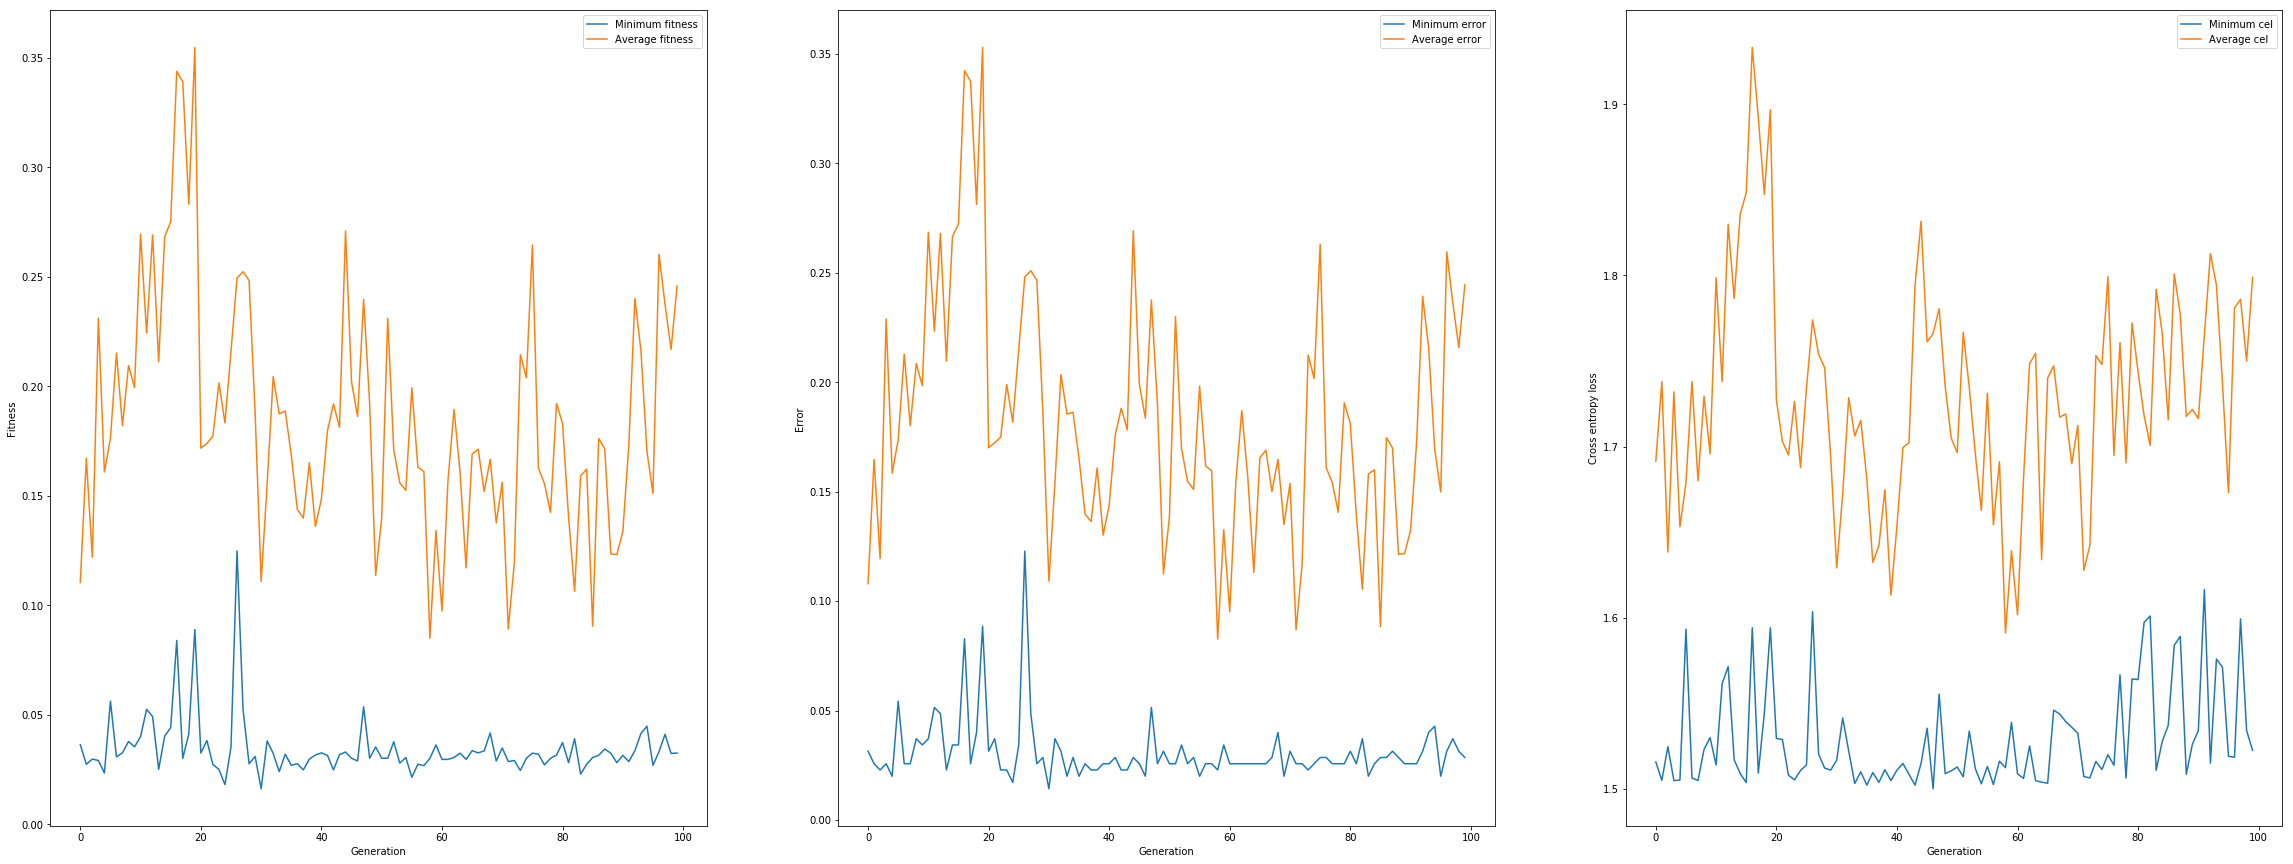

In [18]:
# plot the minimum fitness, minimum error, and minimum cel for each generation and also avg fitness, avg error, and avg cel for each generation in the two separate plots
# first flatten the dict
flat_dict = {}
for key, value in ea.model_metric_dict.items():
    for key2, value2 in value.items():
        flat_dict[key2] = value2

# create minumum plot 
min_fitness = []
min_error = []
min_cel = []
# find min value for each generation
for key, value in ea.model_metric_dict.items():
    fitness = []
    error = []
    cel = []
    for key2, value2 in value.items():
        fitness.append(value2['fitness'])
        error.append(value2['error'])
        cel.append(value2['cel'])
    min_fitness.append(np.min(fitness))
    min_error.append(np.min(error))
    min_cel.append(np.min(cel))

# create average plot
avg_fitness = []
avg_error = []
avg_cel = []
for key, value in ea.model_metric_dict.items():
    fitness = []
    error = []
    cel = []
    for key2, value2 in value.items():
        fitness.append(value2['fitness'])
        error.append(value2['error'])
        cel.append(value2['cel'])
    avg_fitness.append(np.mean(fitness))
    avg_error.append(np.mean(error))
    avg_cel.append(np.mean(cel))

# plot the results
plt.figure(figsize=(40, 15))
plt.subplot(1, 3, 1)
plt.plot(min_fitness, label='Minimum fitness')
plt.plot(avg_fitness, label='Average fitness')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.legend()
plt.subplot(1, 3, 2)
plt.plot(min_error, label='Minimum error')
plt.plot(avg_error, label='Average error')
plt.xlabel('Generation')
plt.ylabel('Error')
plt.legend()
plt.subplot(1, 3, 3)
plt.plot(min_cel, label='Minimum cel')
plt.plot(avg_cel, label='Average cel')
plt.xlabel('Generation')
plt.ylabel('Cross entropy loss')
plt.legend()
plt.show()

# save the results
plt.savefig('fitness_error_cel.png')
plt.close()

